# Deep-learning-based identification of protein nanobarcodes

This notebook contains the code necessary for using our trained deep neural network for identification of protein nanobarcodes from confocal images. 

Current setup in the code loads hyperparameters and network weights from the ```../network_params``` folder. These files will be downloaded from an ftp server the first time the notebook is run.

If you wish, you can use this notebook for training of the network with new data.

This notebook depends on the included Python package ```deep_nanobarcode```. For instruction on how to set up the library, see the ```README.md``` file or visit the github page at https://github.com/noegroup/deep_nanobarcode.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm

import os, glob, urllib, json, pickle
import torch,tifffile

### Importing the deep_nanobarcode library, which initially does a check on PyTorch installation and CUDA availability:

In [2]:
from deep_nanobarcode import dataset_handler
from deep_nanobarcode import model
from deep_nanobarcode import image_processing

GPU is available! :)
CUDA device name: NVIDIA GeForce RTX 3090
CUDA version: 11.7
PyTorch version: 2.0.1+cu117


### Setting up IO paths, as well as specifying which protein expression/imaging condition among the available training data is to be used:

In [3]:
series_number = 15

output_folder = f"../output/series_{series_number}"
network_params_folder = "../network_params"
training_data_folder = "../training_data"
example_folder = "../examples"

dataset_expression_time = "24h"
dataset_scaling = "whitened"
dataset_gain = "550"

ext_str = f"{dataset_expression_time}_{dataset_scaling}_gain_{dataset_gain}"

saved_net_filename = f"weights_series_{series_number}_trained_on_{ext_str}.pth"
dataset_filename = f"kpca_input_{ext_str}.pkl"

for _data_folder, _data_filename in zip([network_params_folder, training_data_folder],
                                        [saved_net_filename, dataset_filename]):
    
    if not glob.glob(f"{_data_folder}/{_data_filename}"):

        print(f"Downloading {_data_filename}...")

        urllib.request.urlretrieve(f"https://ftp.mi.fu-berlin.de/pub/cmb-data/deep_nanobarcode/{_data_filename}",
                           f"{_data_folder}/{_data_filename}")
    else:
        
        print(f"{_data_filename} is already present!")

weights_series_15_trained_on_24h_whitened_gain_550.pth is already present!
kpca_input_24h_whitened_gain_550.pkl is already present!


### The dataset object manages input training data, its shuffling, train/test split, and data augmentation:

In [4]:
dataset = dataset_handler.NanobarcodeDataset(brightness_data_file_name=f"{training_data_folder}/{dataset_filename}",
                                             train_val_test_split_frac=(0.8, 0.1, 0.1),
                                             do_brightness_augmentation=True,
                                             brightness_augmentation_factor=0.9,
                                             verbose=True)

loading data from ../training_data/kpca_input_24h_whitened_gain_550.pkl...
Brightness data loaded for: 
['ENDO', 'GFP', 'GalNact', 'KDEL', 'LifeAct', 'NLS', 'SNAP25', 'STX4', 'STX6', 'TOM70', 'Vti1a', 'Blank']
Data for ENDO with id 0
Brightness data size: (10, 10000)
Brightness data mean: [ 8.64123409  0.29129287 -0.46245223  0.29355565  0.04670625 -0.47846454
  0.22373186 -0.52377879  0.3427327   2.73015611]
Brightness data std: [7.7830247  0.86145197 0.22490737 0.24733357 0.67353665 0.20026225
 0.1485532  0.13406924 0.35499088 4.11224751]
Data for GFP with id 1
Brightness data size: (10, 10000)
Brightness data mean: [ 2.77167331  0.2107618  -0.80013888  0.57079622  5.22770096 -0.52174218
  0.55602149 -0.91916568  0.56485115  0.8931479 ]
Brightness data std: [1.59493585 1.12657253 0.38007754 0.17618989 2.62554567 0.64465791
 0.13809549 0.18216295 0.15921684 0.56804887]
Data for GalNact with id 2
Brightness data size: (10, 10000)
Brightness data mean: [11.0995508   0.38254327 -0.577453

### Getting the names of labeled proteins from the dataset:

In [5]:
print(dataset.id_to_protein_name)

['ENDO', 'GFP', 'GalNact', 'KDEL', 'LifeAct', 'NLS', 'SNAP25', 'STX4', 'STX6', 'TOM70', 'Vti1a', 'Blank']


### Checking the training data for a specified channel and protein (feel free to change): 

In [6]:
channel_ind = 8
protein_ind = 3

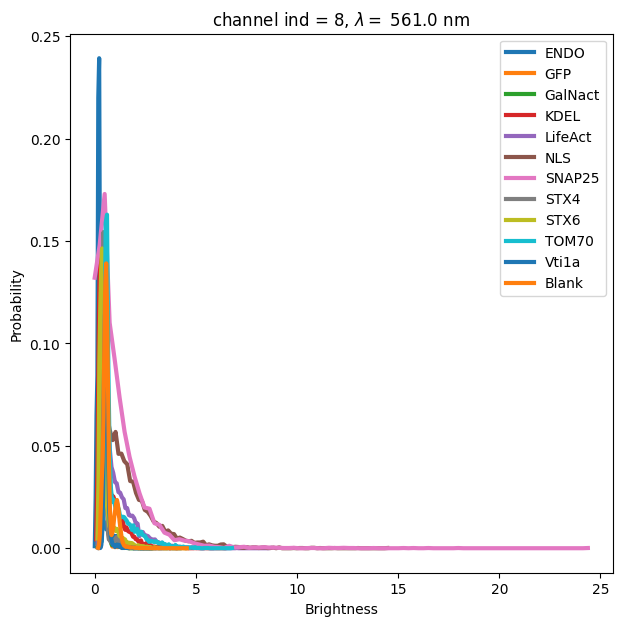

In [7]:
plt.figure(figsize=(7, 7))

for _pr in dataset.protein_names:
    
    data = dataset.brightness_data[_pr]["data"][channel_ind, :]
    
    hist, bin_edges = np.histogram(data, bins=100)
    hist = hist / np.sum(hist)
    plt.plot(bin_edges[:-1], hist, label=_pr, linewidth=3)

plt.title(f"channel ind = {channel_ind}, $\lambda = $ {dataset_handler.channel_wavelength[channel_ind]} nm")
plt.ylabel('Probability')
plt.xlabel('Brightness')

plt.legend()

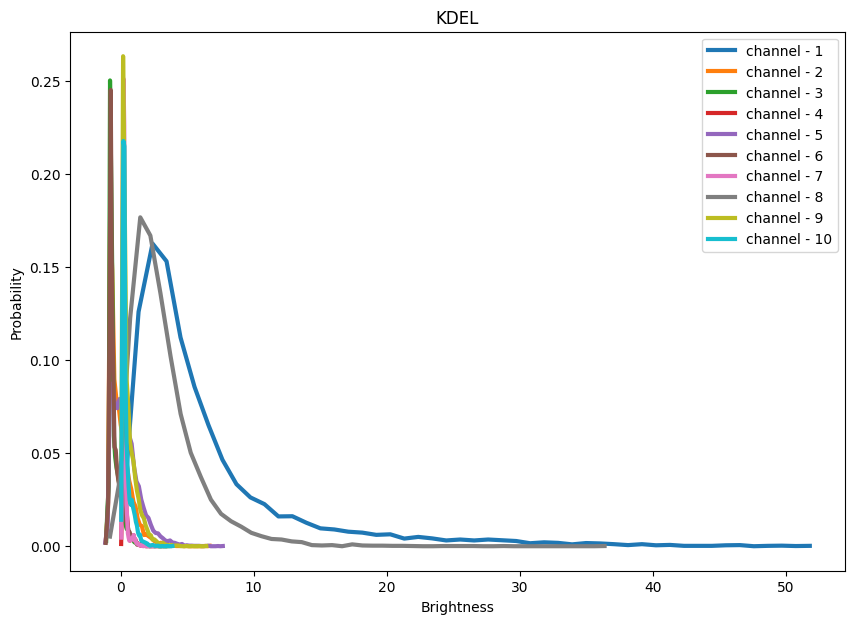

In [8]:
protein_name = dataset.id_to_protein_name[protein_ind]

plt.figure(figsize=(10, 7))

for i in range(dataset_handler.n_channels):
    
    data = dataset.brightness_data[protein_name]["data"][i]

    hist, bin_edges = np.histogram(data, bins=50)
    hist = hist / np.sum(hist)
    
    plt.plot(bin_edges[:-1], hist, label='channel - ' + str(i + 1), linewidth=3)

plt.title(protein_name)
plt.ylabel('Probability')
plt.xlabel('Brightness')

plt.legend()

### Boolean flags controlling the behavior of the rest of the notebook:

In [9]:
save_net = False
load_net = True
train_net = False
save_figures = False

### Loading network hyperparameters from file:

In [10]:
with open(f"{network_params_folder}/model_config_series_{series_number}.json", 'r') as fp:
    network_parameters = json.load(fp)
    
print(network_parameters)

{'width': 128, 'n_middle_layers': 3, 'resnet_stride': 3, 'cardinality': 4, 'batch_size': 458, 'lr': 0.0005, 'num_data_workers': 8, 'use_resnet': True, 'use_dropout': False, 'dropout_rate': 0.2, 'use_bn': True}


### Setting up the network using the ```model_factory```:

In [11]:
net, train_data_loader, val_data_loader, test_data_loader, optimizer =\
    model.model_factory(dataset, *model.separate_args(network_parameters))

print(net)

NanobarcodeClassifierNet(
  (initial_layers): ModuleList(
    (0): Linear(in_features=10, out_features=69, bias=True)
    (1): CompoundActivationBlock(
      (activation): ReLU()
      (dropout): Identity()
      (batch_norm): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Linear(in_features=69, out_features=128, bias=True)
    (3): CompoundActivationBlock(
      (activation): ReLU()
      (dropout): Identity()
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (middle_layers): ModuleList(
    (0-3): 4 x ModuleList(
      (0-2): 3 x ResidualBlock(
        (identity): Identity()
        (layer): ModuleList(
          (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
        )
        (activation): ModuleList(
          (0-2): 3 x CompoundActivationBlock(
            (activation): ReLU()
            (dropout): Identity()
            (batch_norm): BatchNorm1d(128, e

In [12]:
if load_net:
    net.load_state_dict(torch.load(f"{network_params_folder}/{saved_net_filename}"))

### If the flag ```train_net``` is set to True, the following code will result in the retraining of the network

In [13]:
if train_net:
    losses, accuracies, epoch = model.training_loop(net, train_data_loader, val_data_loader, optimizer,
                                                    starting_epoch=0, num_epochs=120,
                                                    losses=None, accuracies=None,
                                                    save_checkpoint=save_net,
                                                    starting_max_accuracy=max_accuracy,
                                                    save_net_file_name=saved_net_filename)

### Checking the prediction accuracy on the test set:

In [14]:
test_metric = model.calc_metrics(net, test_data_loader)

print("Test accuracy = {:5.2f}%".format(test_metric['overall accuracy'] * 100.0))

print()

print("{:12s}\t{}\t{}\t\t{}\t{}\t{}".format("Protein name", "Precision", "Recall", "F1-score",
                                            "False positive", "False negative"))
print("-" * 100)

for protein_name in dataset.protein_names:
    
    protein_id = dataset.brightness_data[protein_name]["ID"]
    
    print("{:12s}\t{:5.2f}\t\t{:5.2f}\t\t{:5.2f}\t\t{:5.2f}\t\t{:5.2f}"
          .format(protein_name,
                  test_metric["precision"][protein_id] * 100.0,
                  test_metric["recall"][protein_id] * 100.0,
                  test_metric["F1-score"][protein_id] * 100.0,
                  test_metric["percent false positive"][protein_id] * 100.0,
                  test_metric["percent false negative"][protein_id] * 100.0))

Test accuracy = 79.98%

Protein name	Precision	Recall		F1-score	False positive	False negative
----------------------------------------------------------------------------------------------------
ENDO        	79.08		70.67		74.64		 1.56		 2.44
GFP         	94.58		98.27		96.39		 0.47		 0.14
GalNact     	71.67		61.95		66.46		 2.04		 3.17
KDEL        	91.48		85.56		88.42		 0.66		 1.20
LifeAct     	84.97		90.99		87.88		 1.34		 0.75
NLS         	79.45		73.12		76.16		 1.58		 2.24
SNAP25      	78.61		71.12		74.68		 1.61		 2.41
STX4        	60.87		68.90		64.63		 3.69		 2.59
STX6        	64.52		73.40		68.67		 3.36		 2.22
TOM70       	83.84		95.09		89.11		 1.53		 0.41
Vti1a       	77.35		72.33		74.75		 1.77		 2.31
Blank       	95.27		98.40		96.81		 0.41		 0.13


### Predicting nanobarcodes from example confocal images.

#### Change the ```example_ind``` between 0 and 3 to use different files:

Protein with name GalNact detected from filename!


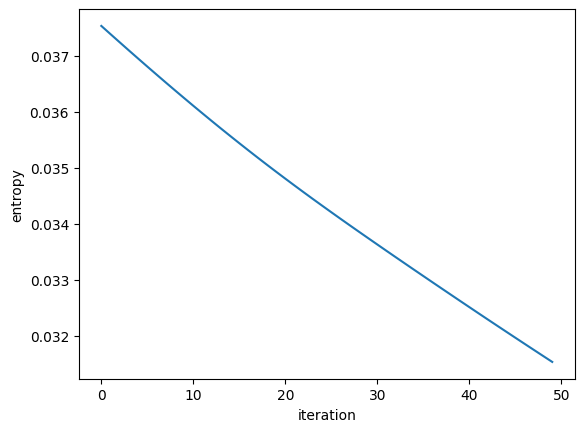

In [15]:
example_ind = 0

# number of entropy minimization iterations used by the "ContrastModifierNet"
n_optim_iter = 50

example_files = ['GalNact_NL1b_CS2_P5_CH11_Gain550',
                 'ENDO_NL1ab_CS2_P2_CH11_Gain550',
                 'KDEL_NL4_CS1_P3_CH11_Gain550',
                 'TOM70_NRXN3Beta-_CS1_P1_CH11_Gain550']

image_file_name = f"{example_folder}/{example_files[example_ind]}.lsm"

result = model.predict_from_image_file(file_name=image_file_name, net=net,
                                       dataset=dataset, n_optim_iter=n_optim_iter,
                                       brightness_scaling_method=dataset_scaling)


plt.plot(result["iterative entropy"][0])
plt.xlabel("iteration")
plt.ylabel("entropy")

if save_figures:
    tifffile.imwrite(f"{output_dir}/false_color_{cropped_name}.tiff", 
                     data=result["cell-halo false-color stack"], compress=6, photometric='rgb')

(-0.5, 511.5, 511.5, -0.5)

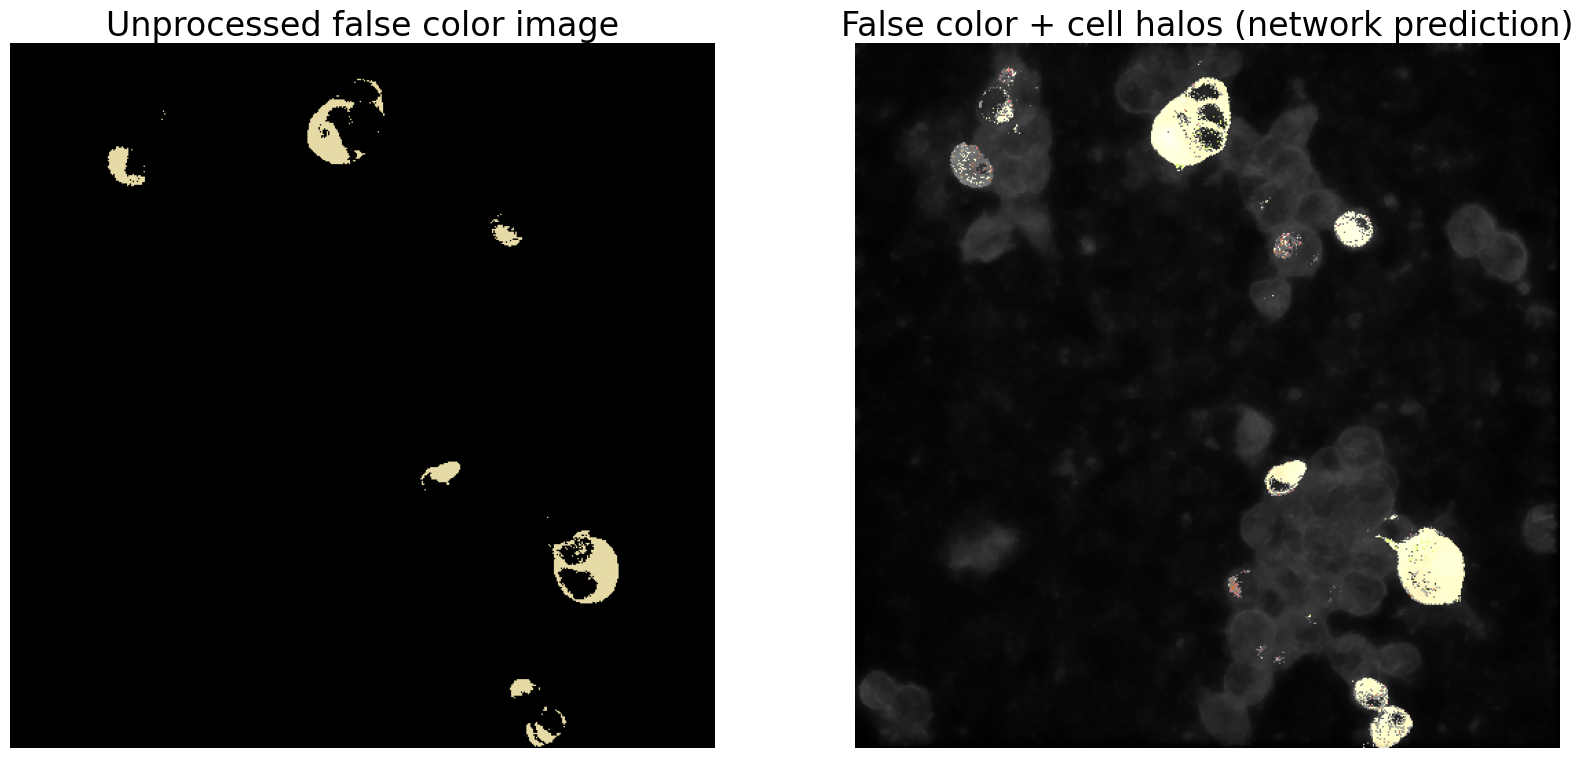

In [16]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(result["unprocessed false-color stack"][0, :, :] / 65535.0)
ax.set_title("Unprocessed false color image", fontsize=24)
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(result["cell-halo false-color stack"][0, :, :] / 65535.0)
ax.set_title("False color + cell halos (network prediction)", fontsize=24)
ax.axis('off')